In [9]:
# notebook for visualizing plane MILP results
from contextlib import contextmanager
import os, sys

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output


In [13]:
@contextmanager
def no_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


In [16]:
print("- Все объекты класса Кеттер подросли на целый метр.")
print("- И какой они длинны?")
with no_output():
    print("101")
print("[Данные Удалены]")


- Все объекты класса Кеттер подросли на целый метр.
- И какой они длинны?
[Данные Удалены]


In [17]:
x = 10e-9
s = (1 + x**2)**(1/2) - 1
print(s)
s1 = x**2 / ((1 + x**2)**(1/2) + 1)
print(s1)


0.0
5.0000000000000005e-17


In [30]:
!python3 ./z-python-scripts/prepare_data.py ./files/plane.lp
!./Cutting_Plane_Generators "./files/data.txt"
!python3 ./z-python-scripts/write_cuts_in_lp.py ./files/cuts.txt ./files/plane.lp


./files/plane.lp
original problem has 2 variables (0 bin, 2 int, 0 impl, 0 cont) and 2 constraints
wrote problem to file /mnt/d/dev/Cutting-Plane-Generators/files/plane.mps
./files/data.txt
Nothing happens
-5.93496(0, 0.219512)(1, -1.05691) len=2

-0.227642(1, -0.0325203) len=2

GMI1 generated: 2
Message!
./files/cuts.txt ./files/plane.lp
original problem has 2 variables (0 bin, 2 int, 0 impl, 0 cont) and 2 constraints
./files/plane_cutted.lp
wrote problem to file /mnt/d/dev/Cutting-Plane-Generators/files/plane_cutted.lp


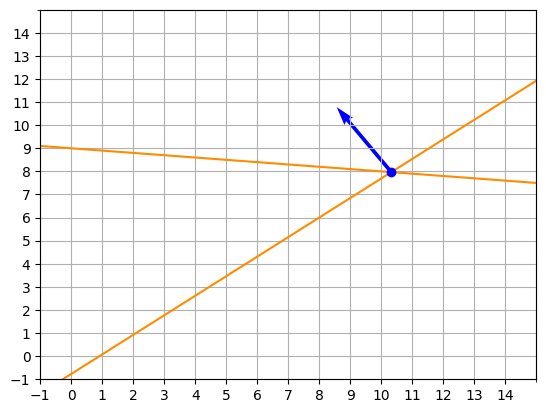

In [19]:
from pysmps import smps_loader as mps
from pyscipopt import LP


signs = mps.load_mps("./files/plane.mps")[5]
obj = mps.load_mps("./files/plane.mps")[6]
a_matrix = mps.load_mps("./files/plane.mps")[7]
rhs = mps.load_mps("./files/plane.mps")[9]['RHS']

constraints = zip(signs, a_matrix, rhs)

x = np.array([-10 + 0.1 * i for i in range(0, 1001)])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.grid(which='both', clip_on=False)
ax.set_ylim(-1, 14)
ax.set_xlim(-1, 14)

major_ticks = np.arange(-1, 15, 1)
minor_ticks = np.arange(-1, 16, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

for sign, row, rhs in constraints:
    if row[1] != 0:
        x = np.array([-10 + 0.1 * i for i in range(0, 1001)])
        y = (rhs - row[0] * x) / row[1]
    else:
        y = np.array([-10 + 0.1 * i for i in range(0, 1001)])
        x = np.ones(len(y)) * rhs / row[0]
    ax.plot(x, y, 'darkorange')

lp = LP()
lp.readLP(b"./files/plane.mps")
lp.solve()
x_r, y_r = lp.getPrimal()

ax.plot(x_r, y_r, 'ob')

V = np.array(-obj)
origin = np.array([[x_r],[y_r]])

ax.quiver(*origin, V[0], V[1], color=['b'], scale=100, clip_on=False)

plt.show()


In [23]:
from pyscipopt import Model

with no_output():
    milp = Model()
    milp.redirectOutput()
    milp.readProblem("./files/plane.lp")
    milp.optimize()


In [24]:
milp_sol_x, milp_sol_y = np.array([milp.getVal(elem) for elem in milp.getVars()])


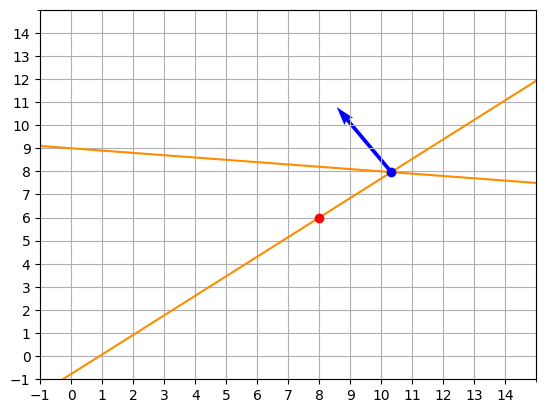

In [25]:
ax.plot(milp_sol_x, milp_sol_y, 'ro')
fig


['0,0.219512', '1,-1.056911', '>=', '-5.93496']
['1,-0.032520', '>=', '-0.227642']


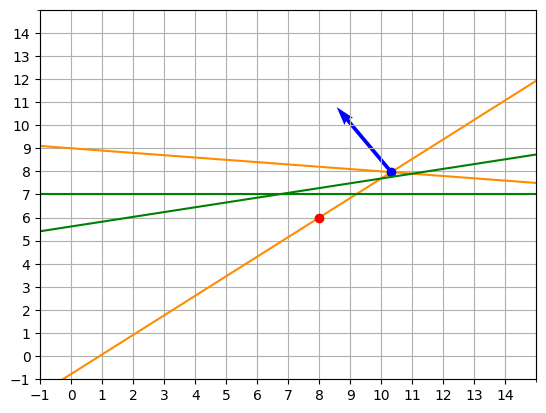

In [26]:
#building cuts
with open("files/cuts.txt", 'r') as f:
    for line in f:
        if line == "": break
        elems = line.split()
        print(elems)
        if elems[0].split(',')[0] == "1":
            rhs = float(elems[2])
            yval = float(elems[0].split(',')[1])
            xval = 0
        elif elems[1] == ">=":
            rhs = float(elems[2])
            xval = float(elems[0].split(',')[1])
            yval = 0
        else:
            xval = float(elems[0].split(',')[1])
            yval = float(elems[1].split(',')[1])
            rhs = float(elems[3])
        if yval != 0:
            x = np.array([-10 + 0.1 * i for i in range(0, 1001)])
            y = (rhs - xval * x) / yval
        else:
            y = np.array([-10 + 0.1 * i for i in range(0, 1001)])
            x = np.ones(len(y)) * rhs / xval
        ax.plot(x, y, 'green')

fig


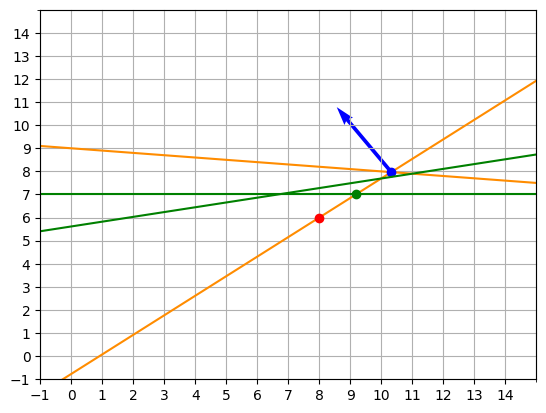

In [27]:
lp = LP()
lp.readLP(b"./files/plane_cutted.lp")
lp.solve()
x_r, y_r = lp.getPrimal()

ax.plot(x_r, y_r, 'og')

fig
